## Importing packages.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.arima.model as ARIMA
import yfinance as yf
from scipy import stats

## Getting stock data
####  *Note : desire history can achieve by add using start data = & end date = as 2nd & 3rd argument in data.

In [52]:
#Defining stock and range

ticker = 'AAPL'
data = yf.download(ticker, period = '12mo', interval = '1d')

print(data)

[*********************100%%**********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2022-09-13  159.899994  160.539993  153.369995  153.839996  152.932739   
2022-09-14  154.789993  157.100006  153.610001  155.309998  154.394058   
2022-09-15  154.649994  155.240005  151.380005  152.369995  151.471420   
2022-09-16  151.210007  151.350006  148.369995  150.699997  149.811279   
2022-09-19  149.309998  154.559998  149.100006  154.479996  153.568970   
...                ...         ...         ...         ...         ...   
2023-09-06  188.399994  188.850006  181.470001  182.910004  182.910004   
2023-09-07  175.179993  178.210007  173.539993  177.559998  177.559998   
2023-09-08  178.350006  180.240005  177.789993  178.179993  178.179993   
2023-09-11  180.070007  180.300003  177.339996  179.360001  179.360001   
2023-09-12  179.490005  180.130005  174.820

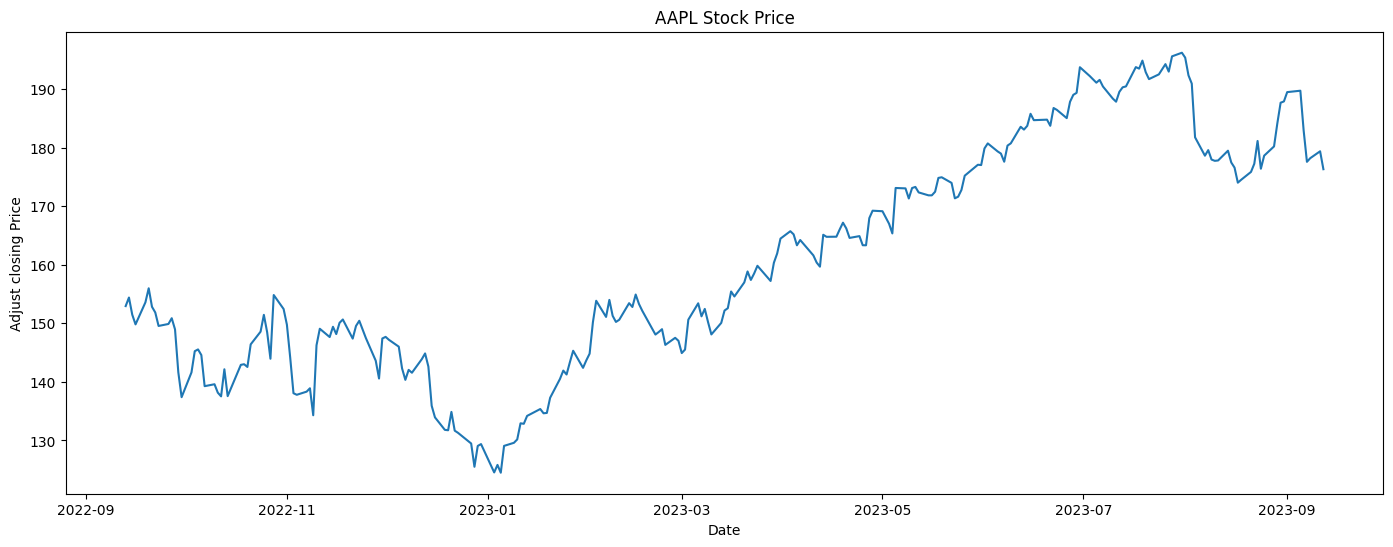

In [53]:
ts = data['Adj Close']

#Plot ts

plt.figure(figsize=(17,6))
plt.plot(ts)
plt.title(f'{ticker} Stock Price')
plt.xlabel("Date")
plt.ylabel("Adjust closing Price")
plt.show()

## Checking for Stationarity

##### Note: The Augmented Dickey-Fuller test can be used to test for a unit root in a univariate process in the presence of serial correlation.

##### Further reading : https://ideas.repec.org/p/qed/wpaper/1227.html

In [54]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts)
print("ADF Statistic :", result[0])
print("p-value", result[1])

ADF Statistic : -0.9864695508147387
p-value 0.7581671772260303


#### Differencing cause data is not staionary

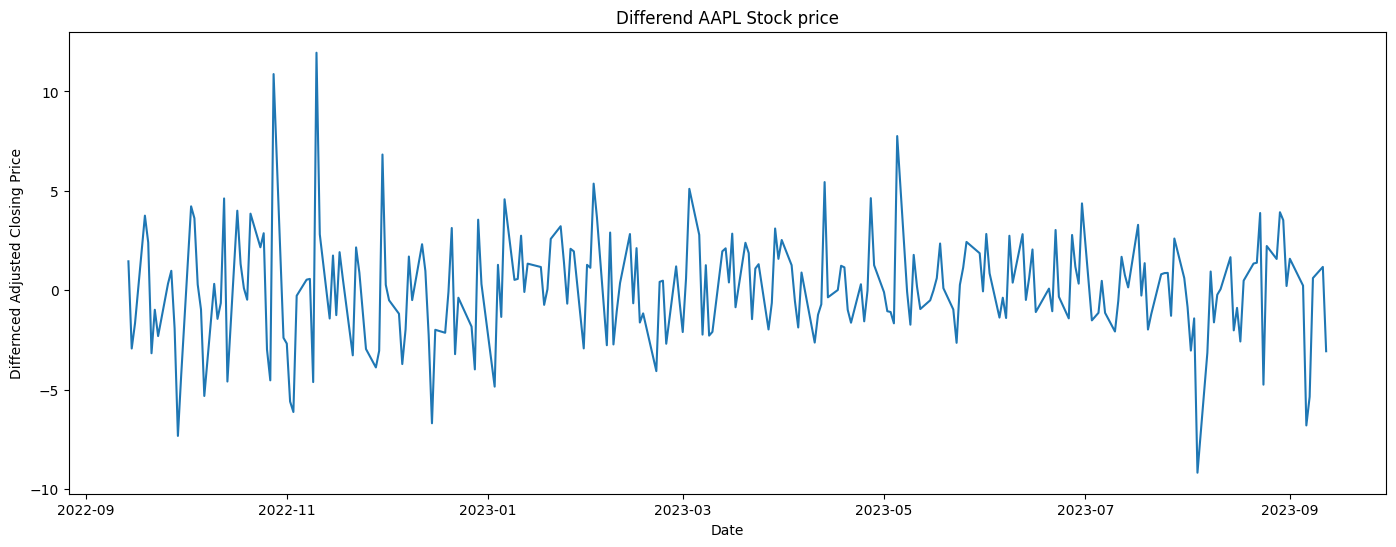

In [55]:
#Perform first-order differencing

ts_diff = ts.diff().dropna()

#Plot
plt.figure(figsize = (17,6))
plt.plot(ts_diff)
plt.title(f"Differend {ticker} Stock price")
plt.xlabel('Date')
plt.ylabel('Differnced Adjusted Closing Price')
plt.show()

### Autocorrelation and Partial Autocorrelation Analysis
##### explaination and ex : https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c#:~:text=Both%20the%20ACF%20and%20PACF,indirect%20correlations%20in%20the%20calculation.

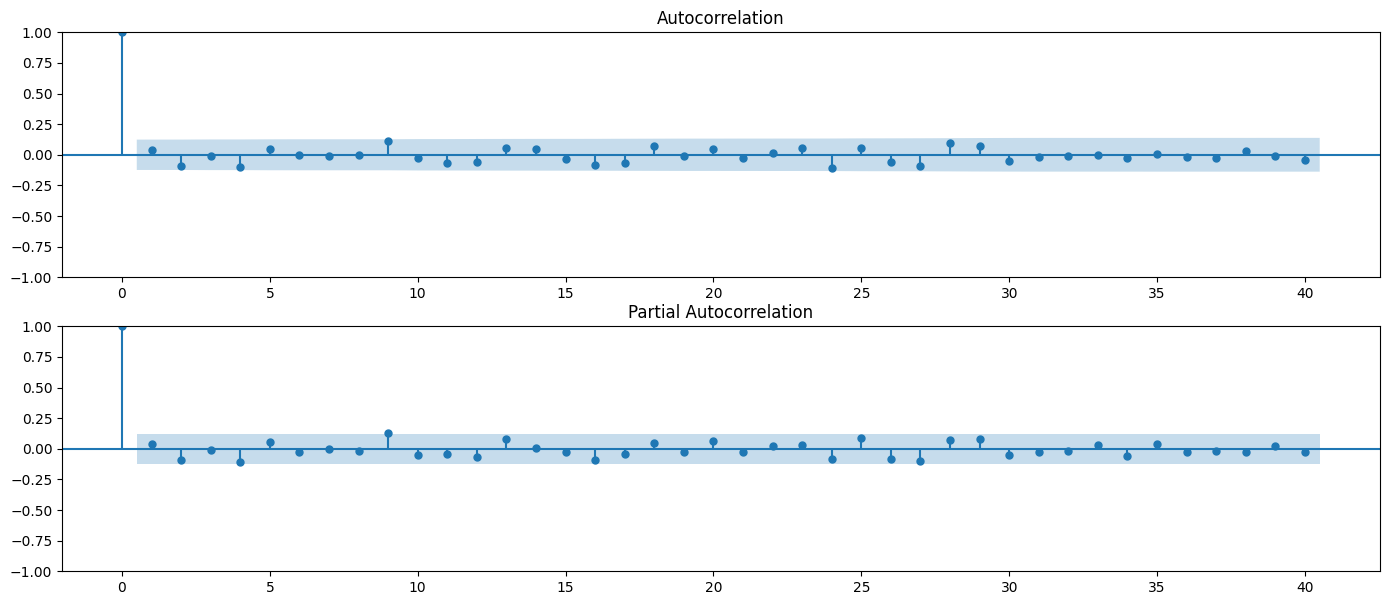

In [56]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig,(ax1, ax2) = plt.subplots(2,1, figsize = (17,7))
plot_acf(ts_diff, ax=ax1, lags = 40)
plot_pacf(ts_diff, ax=ax2, lags = 40)

plt.show()

## Model identification & Estimation
##### Note:  ARIMA forecasting involves determining the orders (p, d, q) of the AutoRegressive Integrated Moving Average (ARIMA) model. in our case its 1,1,1

In [61]:
from statsmodels.tsa.arima.model import ARIMA

# Define the order of the ARIMA model (p, d, q)
p, d, q = 1, 1, 1

# Create an instance of the ARIMA model
model = ARIMA(ts, order=(p, d, q))

# Fit the model to the data
results = model.fit()

# Display model summary
print(results.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                  251
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -598.253
Date:                Wed, 13 Sep 2023   AIC                           1202.506
Time:                        10:30:35   BIC                           1213.071
Sample:                             0   HQIC                          1206.758
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9069      0.038    -23.982      0.000      -0.981      -0.833
ma.L1          0.9996      0.358      2.796      0.005       0.299       1.700
sigma2         6.9452      2.572      2.701      0.0

## Model Diagonstics

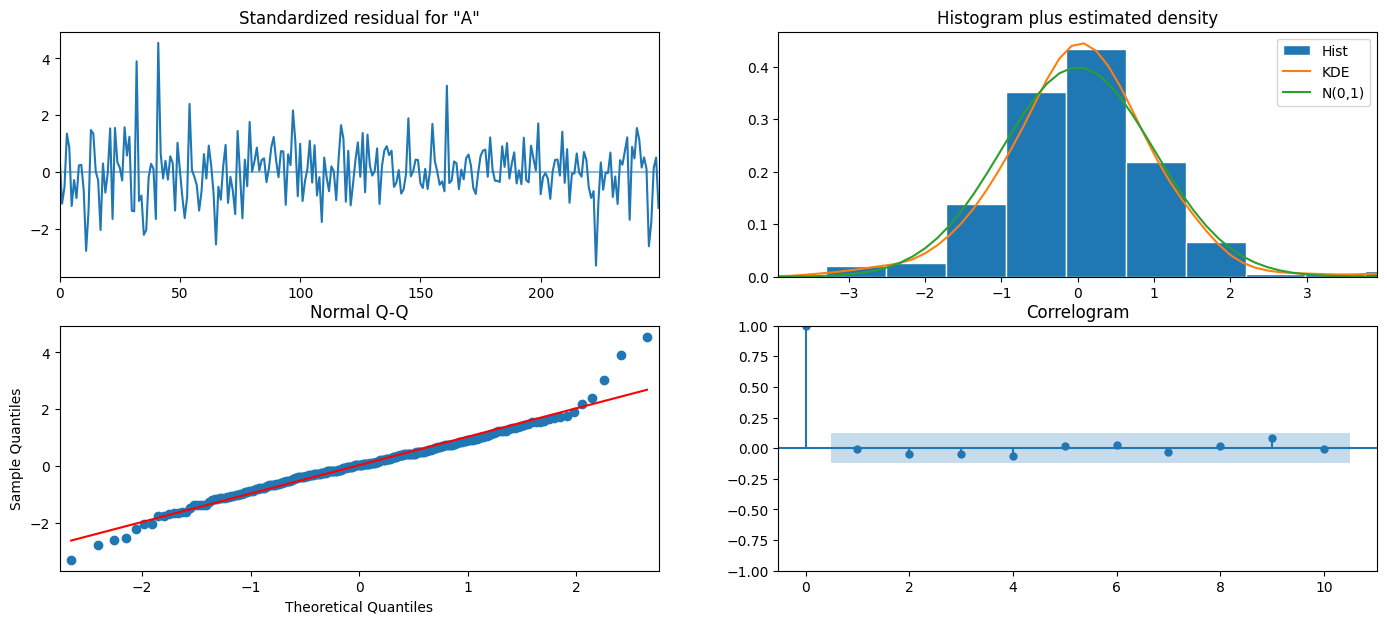

In [58]:
# Check residual diagnostics
results.plot_diagnostics(figsize=(17, 7))
plt.show()


## Forecasting

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


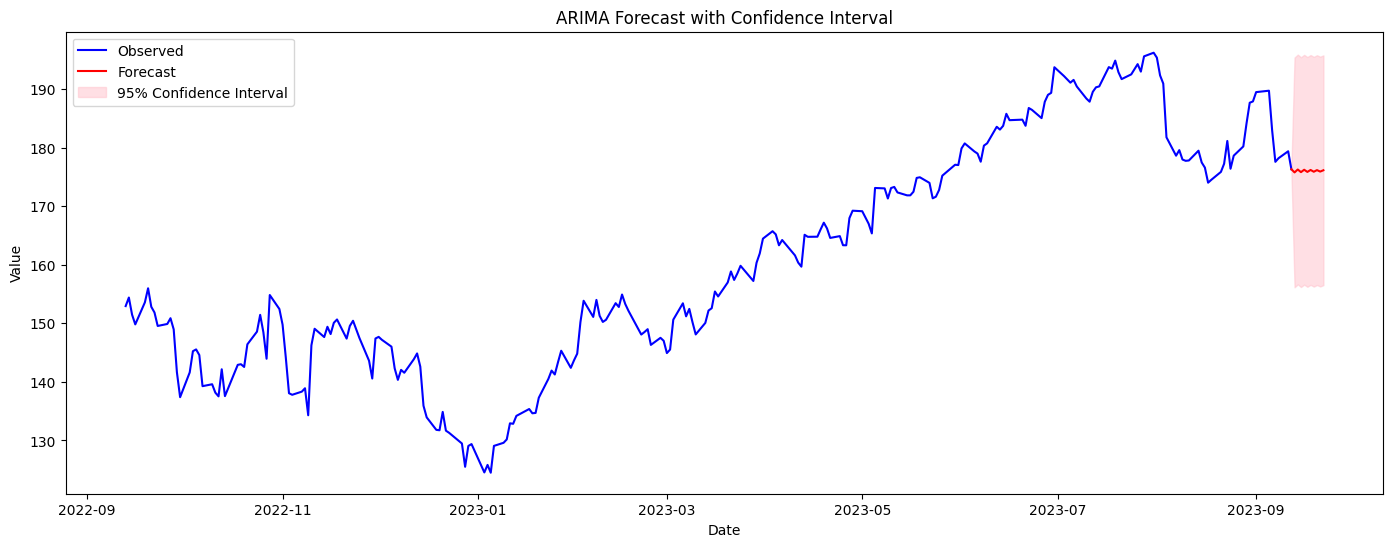

In [60]:
# Forecast the next 10 periods
forecast_periods = 10
forecast = results.forecast(steps=forecast_periods)


alpha = 0.05  # Significance level (e.g., for a 95% confidence interval)
z_critical = stats.norm.ppf(1 - alpha / 2)  # Z-score for the desired confidence level

# Calculate lower and upper bounds of the confidence interval
stderr = results.resid.std()  # Standard error of residuals
lower_bound = forecast - z_critical * stderr
upper_bound = forecast + z_critical * stderr

# Create a time index for the forecasted periods (adjust as needed)
forecast_index = pd.date_range(start=ts.index[-1], periods=forecast_periods+1, freq='D')

# Plot the original data, forecasted values, and confidence intervals
plt.figure(figsize=(17, 6))
plt.plot(ts, label='Observed', color='blue')
plt.plot(forecast_index, [ts.iloc[-1]] + list(forecast), label='Forecast', color='red')
plt.fill_between(forecast_index, [ts.iloc[-1]] + list(lower_bound), [ts.iloc[-1]] + list(upper_bound), color='pink', alpha=0.5, label='95% Confidence Interval')
plt.title('ARIMA Forecast with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()
